In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import scipy.sparse as sparse
import matplotlib
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Figure 4/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
train =  sc.read("../data/train_study.h5ad")
if sparse.issparse(train.X):
    train.X = train.X.A
fmono_ctrl_train = train[(train.obs["cell_type"] == "FCGR3A+ Monocytes") & (train.obs["condition"] == "control")]
fmono_stim_train = train[(train.obs["cell_type"] == "FCGR3A+ Monocytes") & (train.obs["condition"] == "stimulated")]

In [4]:
zheng = sc.read("../data/train_zheng.h5ad")
if sparse.issparse(zheng.X):
    zheng.X = zheng.X.A
fmono_ctrl_zheng = zheng[(zheng.obs["cell_type"] == "FCGR3A+ Monocytes") & (zheng.obs["condition"] == "control")]
if sparse.issparse(fmono_ctrl_zheng.X):
    fmono_ctrl_zheng.X = fmono_ctrl_zheng.X.A

In [5]:
scg = scgen.VAEArith(x_dimension=zheng.shape[1], z_dimension=100, model_path="../models/scGen/study/scgen")
scg.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/study/scgen


In [6]:
conditions = {"stim": "stimulated", "ctrl": "control"}

In [7]:
pred, delta = scg.predict_cross(train.copy(), zheng.copy(), conditions)

In [8]:
cell_types = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]

In [9]:
zheng.obs["cell_type"].replace("CD4 T cells", "CD4-T", inplace=True)
zheng.obs["cell_type"].replace("B cells", "B", inplace=True)
zheng.obs["cell_type"].replace("CD14+ Monocytes", "CD14-Mono", inplace=True)
zheng.obs["cell_type"].replace("NK cells", "NK", inplace=True)
zheng.obs["cell_type"].replace("CD8 T cells", "CD8-T", inplace=True)
zheng.obs["cell_type"].replace("Dendritic cells", "DC", inplace=True)
zheng.obs["cell_type"].replace("FCGR3A+ Monocytes", "F-Mono", inplace=True)

In [10]:
train.obs["cell_type"].replace("CD4 T cells", "CD4-T", inplace=True)
train.obs["cell_type"].replace("B cells", "B", inplace=True)
train.obs["cell_type"].replace("CD14+ Monocytes", "CD14-Mono", inplace=True)
train.obs["cell_type"].replace("NK cells", "NK", inplace=True)
train.obs["cell_type"].replace("CD8 T cells", "CD8-T", inplace=True)
train.obs["cell_type"].replace("Dendritic cells", "DC", inplace=True)
train.obs["cell_type"].replace("FCGR3A+ Monocytes", "F-Mono", inplace=True)

In [11]:
all_adata = sc.AnnData(np.concatenate([zheng.X, pred]),)
all_adata.obs["condition"] = ["control"] * len(zheng.X) + ["pred"] * len(pred)
all_adata.obs["cell_type"]  = zheng.obs["cell_type"].tolist() + zheng.obs["cell_type"].tolist()
all_adata.var_names = train.var_names
fmono_pred = all_adata[(all_adata.obs["condition"] == "pred") & (all_adata.obs["cell_type"] == "F-Mono")]

### Figure 4.b

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'condition' as categorical
... storing 'cell_type' as categorical


saving figure to file ../results/Figures/Figure 4/umap_cross_study_celltype.pdf


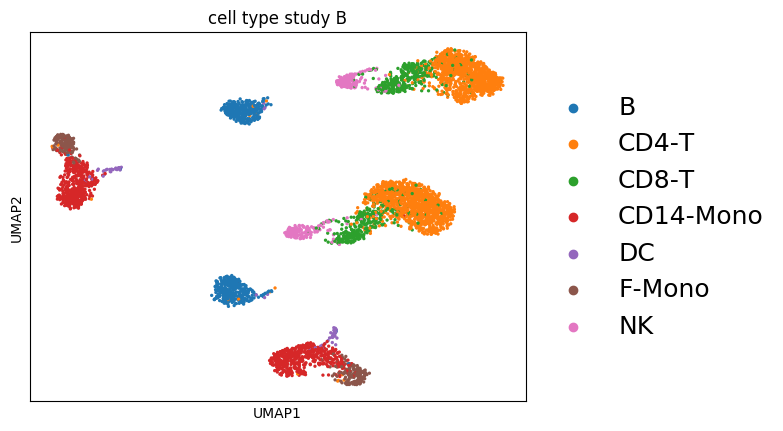

saving figure to file ../results/Figures/Figure 4/umap_cross_study_isg15.pdf


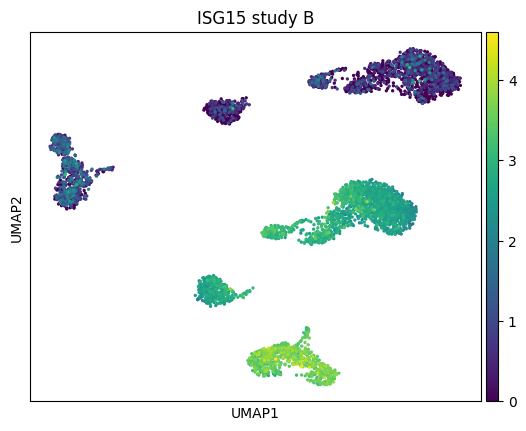

In [12]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
sc.pp.neighbors(all_adata)
sc.tl.umap(all_adata)
sc.pl.umap(all_adata, color = ["cell_type"], title="cell type study B", frameon=True, palette=matplotlib.rcParams["axes.prop_cycle"], legend_fontsize=18, save ="_cross_study_celltype.pdf")
sc.pl.umap(all_adata, color = [ "ISG15"], title="ISG15 study B", frameon=True, palette=matplotlib.rcParams["axes.prop_cycle"], legend_fontsize=14, save ="_cross_study_isg15.pdf")

os.rename(src=os.path.join(path_to_save, "umap_cross_study_celltype.pdf"), 
          dst=os.path.join(path_to_save, "Fig4b_umap_cross_study_celltype.pdf.pdf"))
os.rename(src=os.path.join(path_to_save, "umap_cross_study_isg15.pdf"), 
          dst=os.path.join(path_to_save, "Fig4b_umap_cross_study_isg15.pdf"))

### Figure 4.c

In [13]:
fmono = train[train.obs["cell_type"] == "F-Mono"]
sc.tl.rank_genes_groups(fmono, groupby="condition")
diff_genes = fmono.uns["rank_genes_groups"]["names"]["stimulated"][:5]

... storing 'cell_type' as categorical


0.6666687641901594


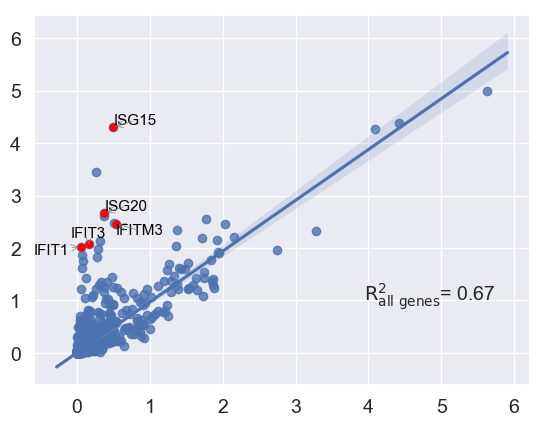

In [14]:
adata = fmono.copy()
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
scgen.plotting.reg_mean_plot(adata, 
                             condition_key="condition",
                             axis_keys={"x": "control", "y": "stimulated"},
                             labels={"x": "", "y": ""},
                             gene_list=diff_genes[:5],
                             path_to_save=os.path.join(path_to_save, f"Fig4c_left_reg_mean.pdf"),
                             legend=False,
                             title="",
                             show=True,
                             x_coeff=0.3)

0.4966684918374419


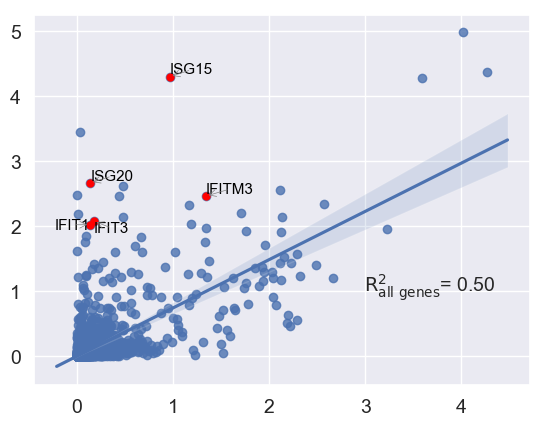

In [15]:
adata = fmono_stim_train.concatenate(fmono_ctrl_zheng)
scgen.plotting.reg_mean_plot(adata, 
                             condition_key="condition",
                             axis_keys={"x": "control", "y": "stimulated"},
                             labels={"x": "", "y": ""},
                             gene_list=diff_genes[:5],
                             path_to_save=os.path.join(path_to_save, f"Fig4c_center_reg_mean.pdf"),
                             legend=False,
                             title="",
                             show=True,
                             x_coeff=0.3)

0.7429848340693882


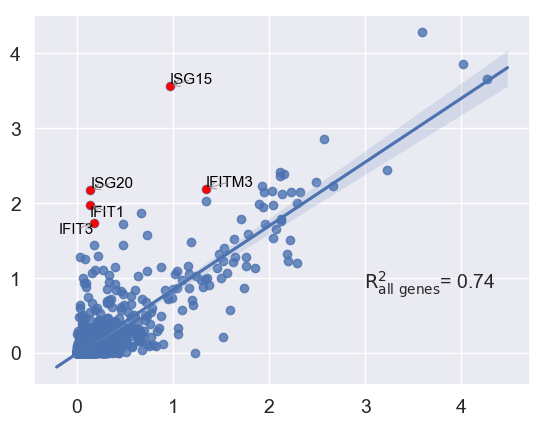

In [16]:
adata = fmono_pred.concatenate(fmono_ctrl_zheng)
scgen.plotting.reg_mean_plot(adata, 
                             condition_key="condition",
                             axis_keys={"x": "control", "y": "pred"},
                             labels={"x": "", "y": ""},
                             gene_list=diff_genes[:5],
                             path_to_save=os.path.join(path_to_save, f"Fig4c_down_reg_mean.pdf"),
                             legend=False,
                             title="",
                             x_coeff=0.3,
                             show=True)

### Figure 4.d

In [17]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=14)

In [18]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375):
    plt.close("all")
    import matplotlib
    import seaborn as sns
    matplotlib.rc('ytick', labelsize=18)
    matplotlib.rc('xtick', labelsize=18)
    plt.figure(figsize=(10, 7))
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
#     offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
#     width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        if put_label:
            autolabel(b)
#         plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
#     plt.xlabel(cat)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=18)
    plt.xticks(x_pos+offset, u, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, filename), dpi=100)
    plt.show()

In [19]:
def calc_R2_mean_var(adata, cell_types, conditions):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        cell_adata = adata[adata.obs["cell_type"] == cell_type]
        print(cell_type, cell_adata.shape)
        r2_mean, r2_var = calc_R2(cell_adata, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars
def calc_R2(adata, conditions=None):
    r_values = np.zeros((1, 100))
    ctrl = adata[adata.obs["condition"] == conditions["ctrl"]]
    stim = adata[adata.obs["condition"] == conditions["stim"]]
    for i in range(100):
        ctrl_idx = np.random.choice(range(0, ctrl.shape[0]), int(0.8 * ctrl.shape[0]))
        stim_idx = np.random.choice(range(0, stim.shape[0]), int(0.8 * stim.shape[0]))
        if sparse.issparse(ctrl.X):
            ctrl.X = ctrl.X.A
            stim.X = stim.X.A
        x = np.average(ctrl.X[ctrl_idx], axis=0)
        y = np.average(stim.X[stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    return r_values.mean(), r_values.std()

In [20]:
cell_types_colnames = ["B", "CD14-Mono", "CD4-T", "CD8-T", "DC", "F-Mono", "NK"]
cell_types = zheng.obs["cell_type"].unique().tolist()
cell_types

['CD4-T', 'B', 'CD14-Mono', 'NK', 'CD8-T', 'F-Mono', 'DC']

In [21]:
train_stim = train[train.obs["condition"] == "stimulated"]
pred_data = all_adata[(all_adata.obs["condition"] == "pred")]

study_adata = train_stim.concatenate(zheng)
pred_adata = zheng.concatenate(pred_data)


study_adata.obs["cell_type"].unique().tolist()

['NK', 'DC', 'CD4-T', 'B', 'F-Mono', 'CD14-Mono', 'CD8-T']

In [22]:
conditions = {"stim": "stimulated", "ctrl": "control"}
study_means, study_vars = calc_R2_mean_var(study_adata, cell_types=cell_types, conditions=conditions)
conditions = {"stim": "pred", "ctrl": "control"}
pred_means, pred_vars = calc_R2_mean_var(pred_adata, cell_types=cell_types, conditions=conditions)

CD4-T (3883, 7000)
B (1215, 7000)
CD14-Mono (1025, 7000)
NK (713, 7000)
CD8-T (781, 7000)
F-Mono (2334, 7000)
DC (444, 7000)
CD4-T (2288, 7000)
B (684, 7000)
CD14-Mono (960, 7000)
NK (308, 7000)
CD8-T (632, 7000)
F-Mono (300, 7000)
DC (74, 7000)


In [23]:
all_means = np.concatenate([study_means, pred_means])
all_vars = np.concatenate([study_vars, pred_vars])
all_types = ["Study A"] * 7 + ["Prediction"] * 7
models = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": models})
df

,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.736802,0.001955,Study A,CD4-T
1,0.666192,0.004095,Study A,B
2,0.442564,0.005038,Study A,CD14-Mono
3,0.642359,0.004832,Study A,NK
4,0.701708,0.003940,Study A,CD8-T
5,0.494170,0.003407,Study A,F-Mono
6,0.484394,0.009198,Study A,DC
7,0.787296,0.001472,Prediction,CD4-T
8,0.754325,0.002537,Prediction,B
9,0.743895,0.002263,Prediction,CD14-Mono


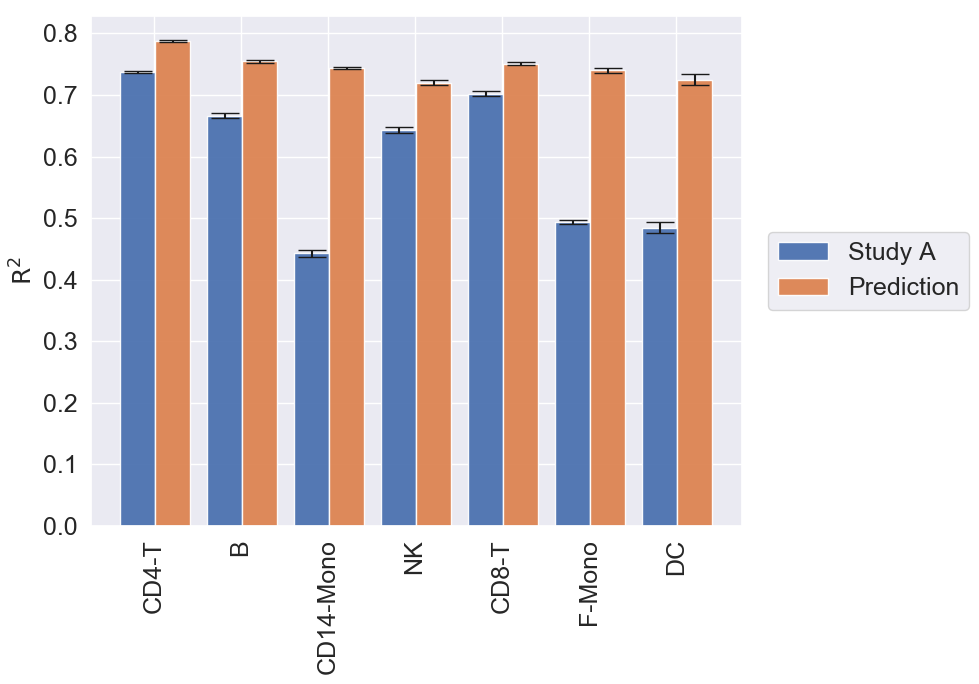

In [24]:
sns.set()
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", legend=True, put_label=False, filename="Fig4d_celltypes_barplots.pdf")